In [1]:
# Libraries

import json
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r

from source.python.cnn import core     as cnn_core
from source.python.cnn import dataset  as cnn_dataset
from source.python.cnn import model    as cnn_model
from source.python.cnn import mutation as cnn_mutation
from source.python.cnn import plot     as cnn_plot
from source.python.cnn import util     as cnn_util
from source.python.io  import loader   as data_loader

# 1. Setup

In [4]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp07-zrimec2020', 'regression')
OUT_MODEL = os.path.join(OUT_DATA, 'model')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)
os.makedirs(OUT_PLOT,  exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_MODEL}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\regression
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\regression\model
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-zrimec2020\regression\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [5]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

for key, value in SYSTEM.items() :
	print('{:16s} : {}'.format(key, value))

platform_python  : 3.10.7
platform_system  : Windows
platform_release : 10
platform_version : 10.0.19044
cpu_name         : N/A
cpu_count        : 12
cuda_name        : NVIDIA GeForce RTX 3060 Ti
cuda_available   : True
cuda_devices     : 1
memory_total     : 31.924 GB
memory_available : 22.662 GB


In [6]:
# Load the input transcript features

mutation_gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'mutation-features-bp2150.fasta'),
	to_string = True
)

mutation_gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-frequency.npz')
)

mutation_gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'mutation-features-stability.npz')
)

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-values.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

# 2. Config

In [7]:
# Define basic data parameters

config = {
	'random_seed' : None,
	'batch_size' : {
		'train' : 64,
		'valid' : 64,
		'test'  : 64
	},
	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	}
}

# Ensure correct
config['output']['length'] = len(tpm_order[config['output']['group0']])

In [8]:
# Get the correct output group

gene_targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}

In [9]:
# Get the correct output order

tpm_order = tpm_order[config['output']['group0']]

In [10]:
# Lock random

config['random_seed'] = cnn_core.lock_random(
	seed = config['random_seed'],
	generate_seed = True
)

print('Random seed : {}'.format(config['random_seed']))

Random seed : 874030153


# 3. Dataloaders

## 3.1 Normal

In [11]:
# Create dataloader

dataset = cnn_dataset.to_dataset(
	sequences   = gene_sequences,
	features    = gene_frequency,
	targets     = gene_targets,
	expand_dims = None
)

dataloaders = cnn_dataset.to_dataloaders(
	dataset     = dataset,
	split_size  = config['split_size'],
	batch_size  = config['batch_size'],
	random_seed = config['random_seed']
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [12]:
# Display train dataloader

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size']['train']
)

Dataloader  batch  size :     64
Dataloader  batch count :    304
Dataloader sample count : 19,456

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


In [13]:
# Display valid dataloader

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size']['valid']
)

Dataloader  batch  size :     64
Dataloader  batch count :     76
Dataloader sample count :  4,864

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


In [14]:
# Display test dataloader

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size']['test']
)

Dataloader  batch  size :     64
Dataloader  batch count :     95
Dataloader sample count :  6,080

     Key shape : (64,)
Sequence shape : torch.Size([64, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 5])


## 3.2 Mutation

In [15]:
# Create mutation dataloader

mutation_dataloader = cnn_mutation.create_dataloader(
	sequences   = mutation_gene_sequences,
	features    = mutation_gene_frequency,
	targets     = gene_targets,
	expand_dims = None,
	random_seed = config['random_seed']
)

In [16]:
# Display mutation dataloader

cnn_dataset.show_dataloader(
	dataloader = mutation_dataloader,
	batch_size = 1
)

Dataloader  batch  size :      1
Dataloader  batch count :  2,525
Dataloader sample count :  2,525

     Key shape : (1,)
Sequence shape : torch.Size([1, 4, 2150])
 Feature shape : torch.Size([1, 64])
  Target shape : torch.Size([1, 5])


# 4. Model

## 4.1 Structure

In [17]:
# Create and display the model structure

model = Zrimec2020r(params = {
	'other' : {
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.1
	},
	'conv1' : {
		'filters' : 64,
		'kernel'  : 21,
		'padding' : 'none'
	},
	'conv2' : {
		'filters' : 64,
		'kernel'  : 31,
		'padding' : 'none'
	},
	'conv3' : {
		'filters' : 128,
		'kernel'  : 5,
		'padding' : 'same'
	},
	'maxpool1' : {
		'kernel'  : 9,
		'padding' : 'same'
	},
	'maxpool2' : {
		'kernel'  : 3,
		'padding' : 'same'
	},
	'maxpool3' : {
		'kernel'  : 3,
		'padding' : 'same'
	},
	'fc1' : {
		'features' : 128
	},
	'fc2' : {
		'features' : 256
	},
	'fc3' : {
		'features' : config['output']['length']
	}
})

model.summary(
	batch_size  = config['batch_size']['train'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020r                              [64, 4, 2150]             [64, 5]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 256]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 64, 2130]            5,440
│    └─ReLU: 2-2                         [64, 64, 2130]            [64, 64, 2130]            --
│    └─BatchNorm1d: 2-3                  [64, 64, 2130]            [64, 64, 2130]            128
│    └─Dropout: 2-4                      [64, 64, 2130]            [64, 64, 2130]            --
│    └─MaxPool1d: 2-5                    [64, 64, 2130]            [64, 64, 426]             --
│    └─Conv1d: 2-6                       [64, 64, 426]             [64, 64, 396]             127,040
│    └─ReLU: 2-7                         [64, 64, 396]             [64, 64, 396]             --
│    └─BatchNorm1d: 2-8   

In [18]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

## 4.2 Parameters

In [19]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean',
	weights   = None
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 0.001,
	betas        = (
		0.970,
		0.999
	),
	weight_decay = 0.01
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 5,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'),
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'),
	'epochs'    : 25,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		'mse' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
		'mae' : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		'r2'  : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'r2')
	}
}

## 4.3 Training

In [20]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

## 4.4 Visualization

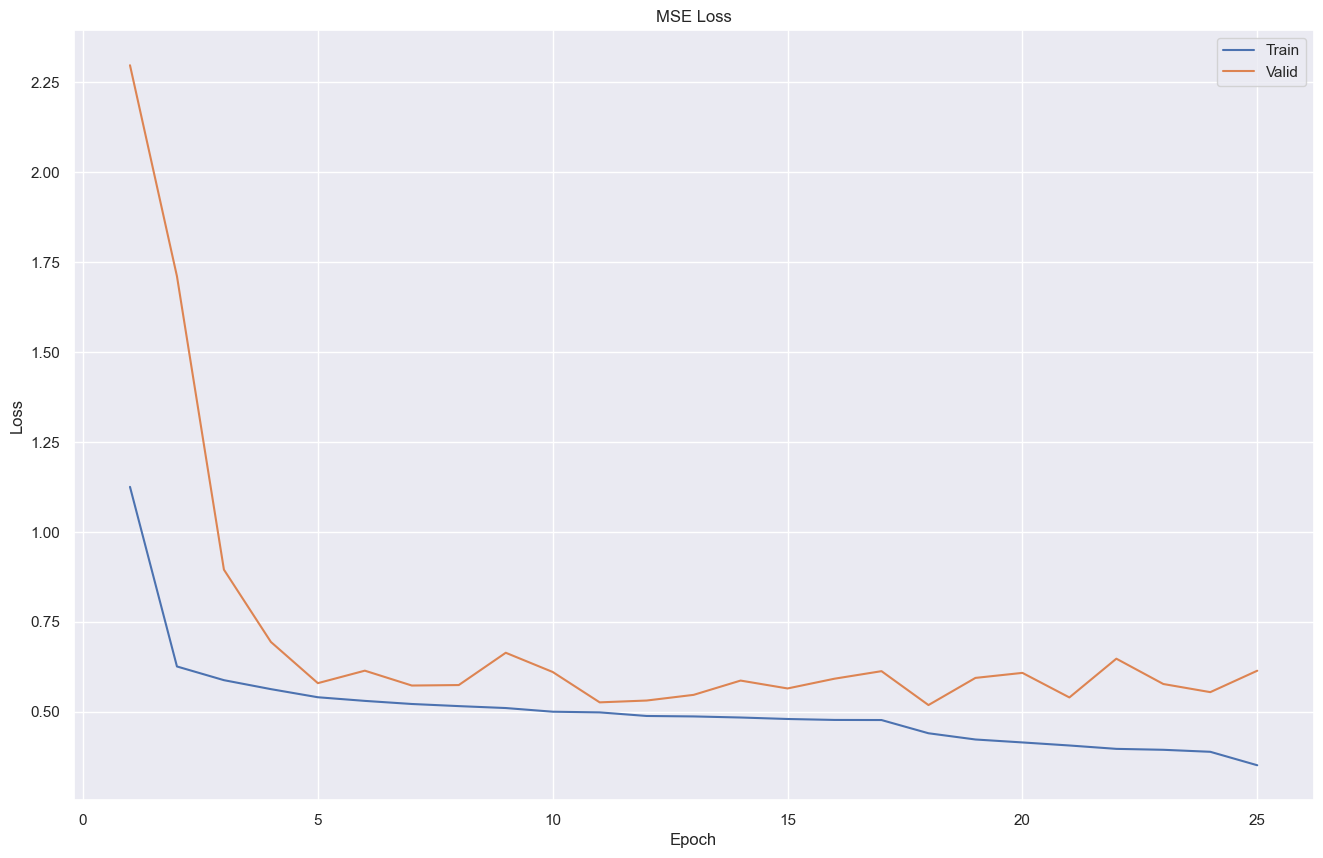

In [21]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

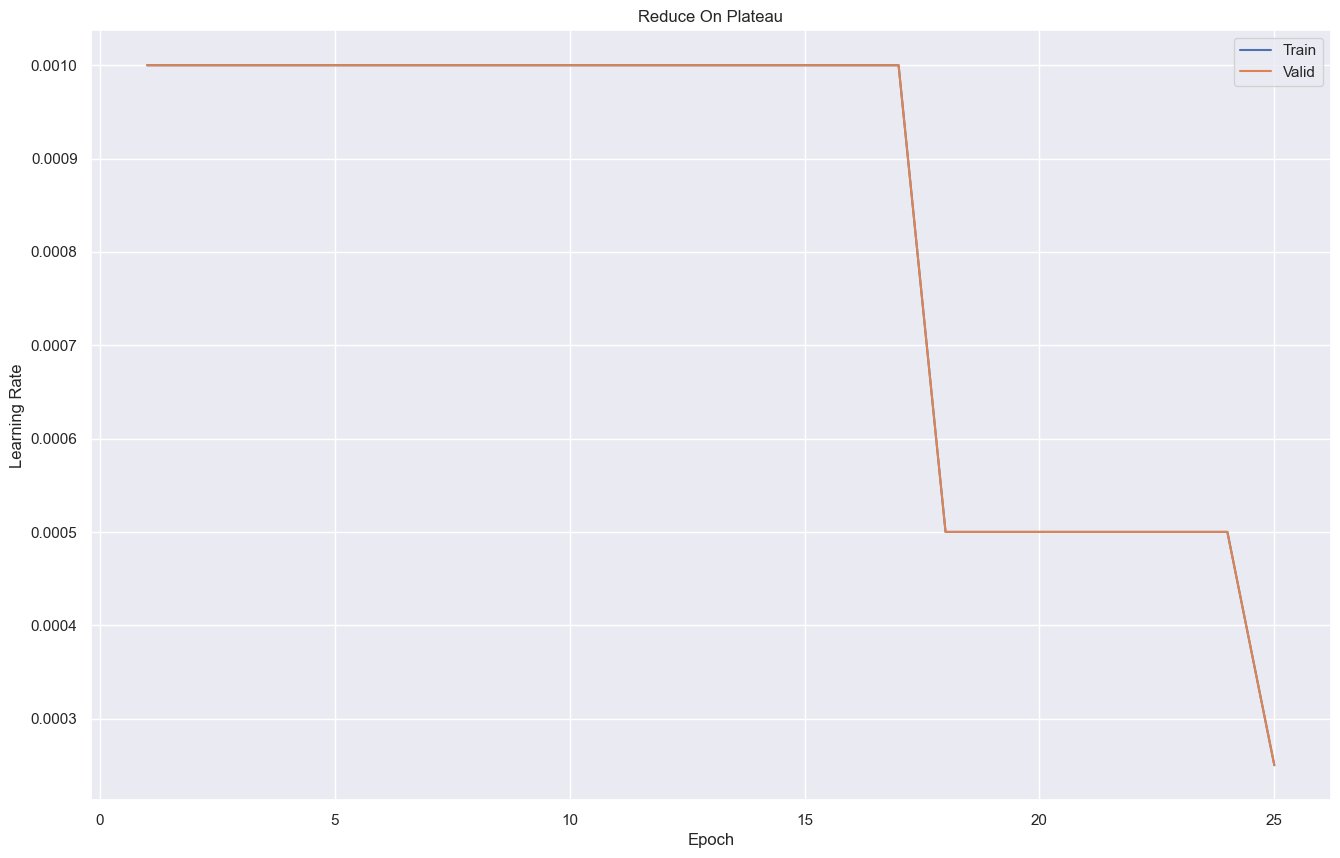

In [22]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

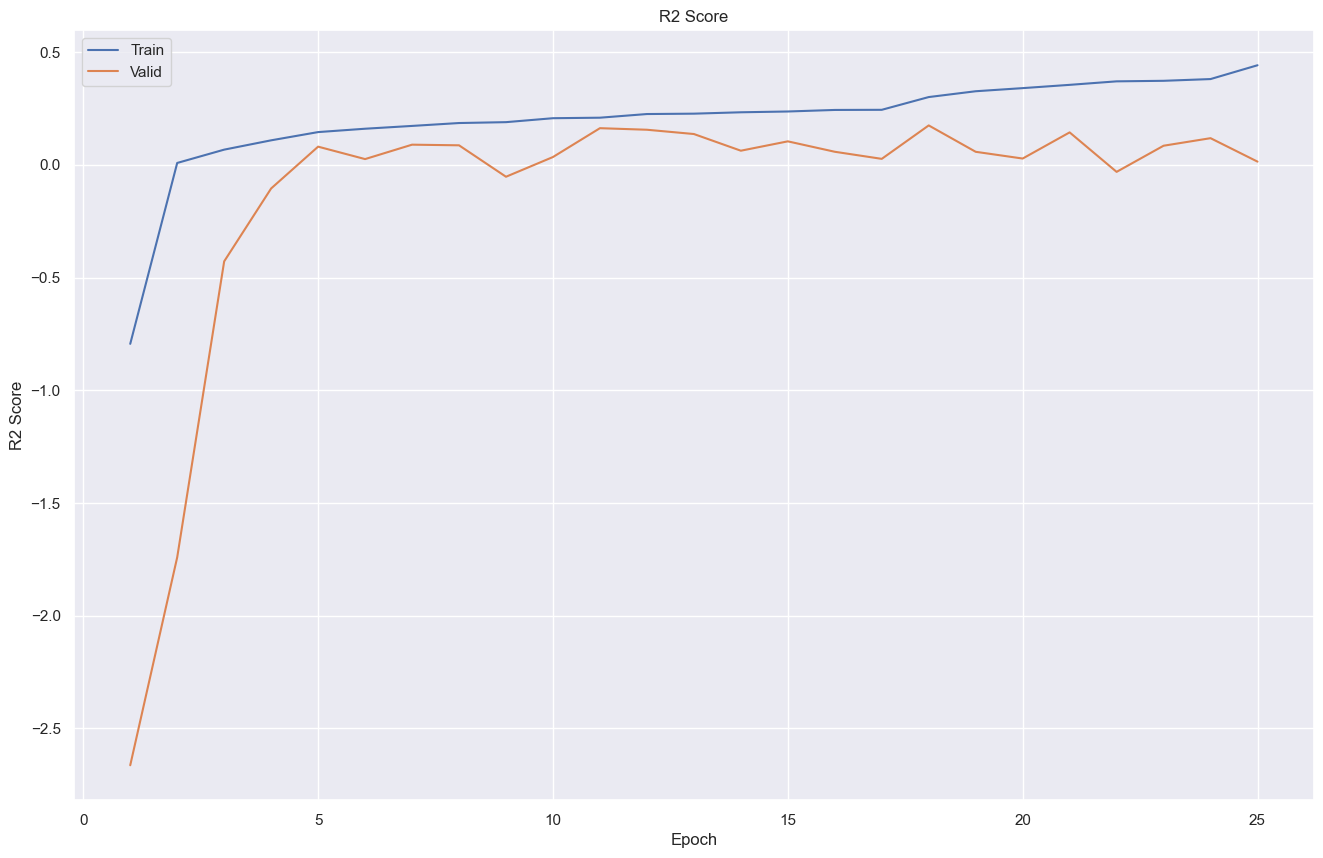

In [23]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

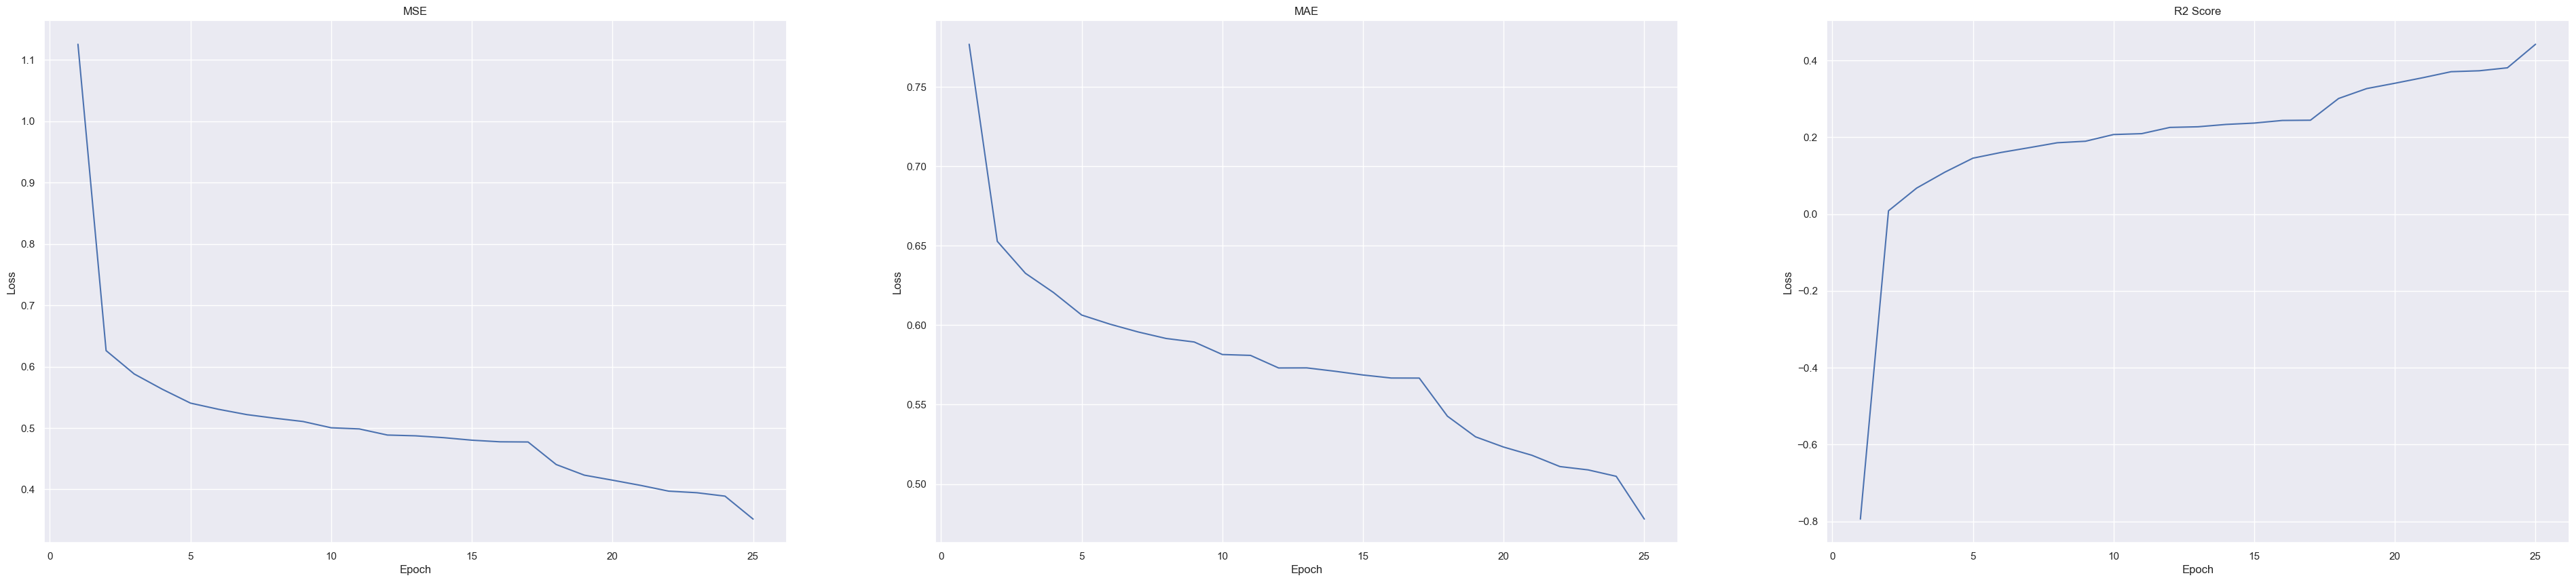

In [24]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

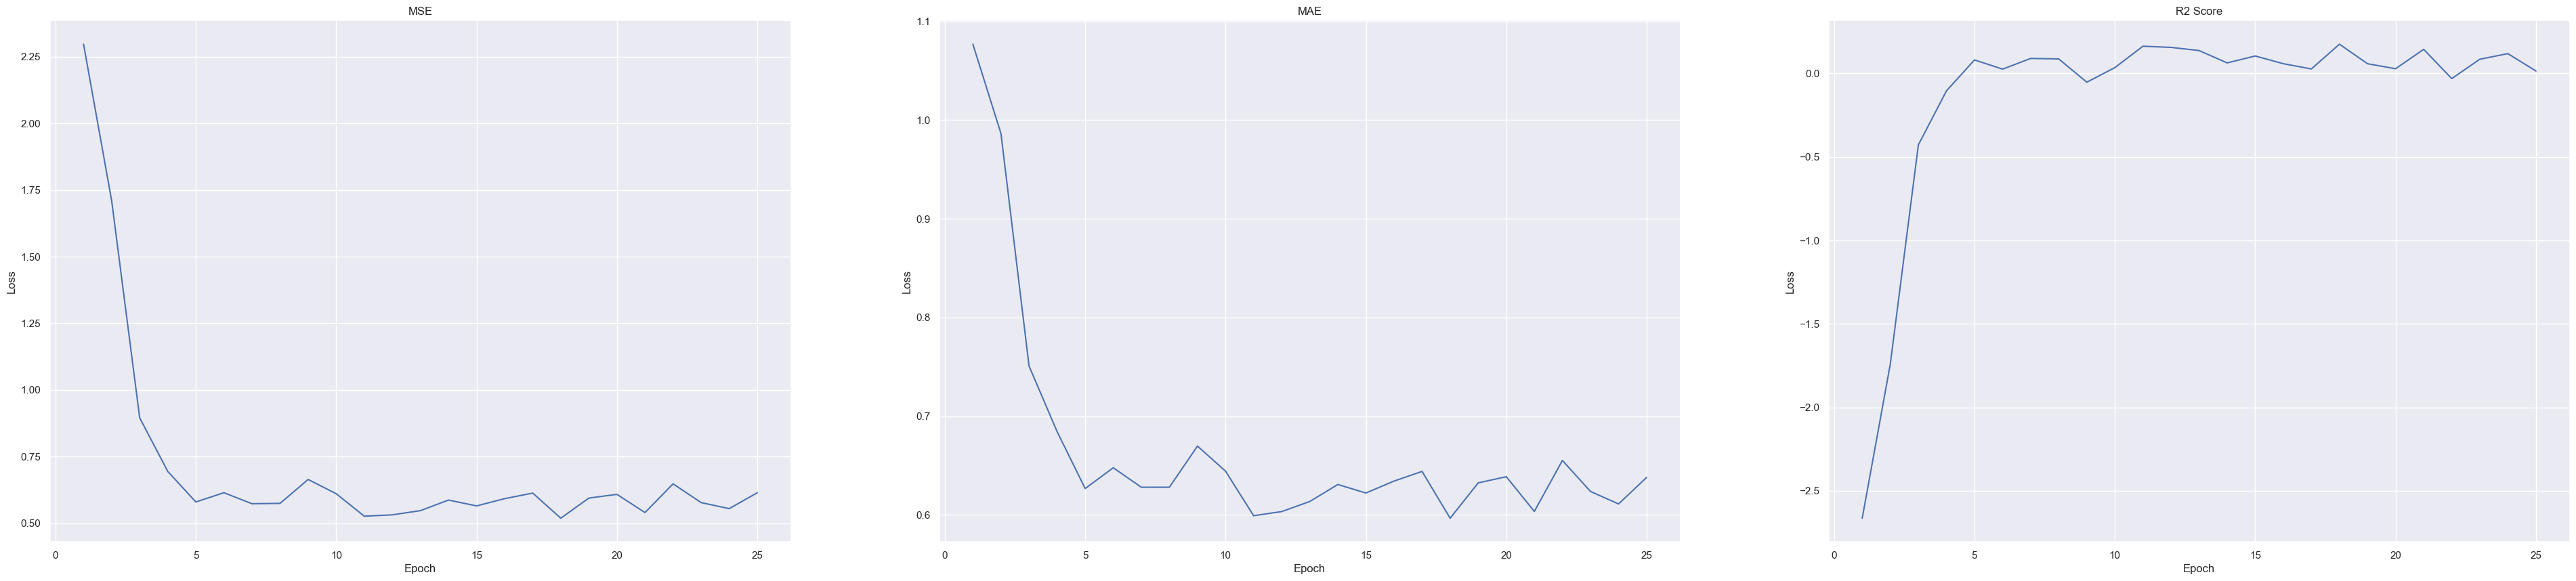

In [25]:
# Display the validation metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

# 5. Evaluation

## 5.1 Last Model

### 5.1.1 Evaluation

In [26]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 25
Loss  : 0.61431


<All keys matched successfully>

In [27]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.04665
MAE Loss :  0.62833
MSE Loss :  0.59650


### 5.1.2 Custom

In [28]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT1G49840.1
True : [ 1.79944    1.49627    1.72934    1.82005    1.65008]
Pred : [ 1.49225    1.16084    1.37655    1.25876    1.31480]
 MAE : [ 0.30720    0.33543    0.35280    0.56128    0.33528]
 MSE : [ 0.09437    0.11251    0.12447    0.31504    0.11241]
 R2  : [ 0.24490    0.21191    0.20243    0.27815    0.25301]

Gene : AT3G19800.1
True : [ 2.50211    2.66534    0.74221    2.18855    2.49340]
Pred : [ 2.03969    1.71181    1.92848    1.81437    1.87136]
 MAE : [ 0.46242    0.95353    1.18627    0.37418    0.62204]
 MSE : [ 0.21383    0.90922    1.40724    0.14001    0.38693]
 R2  : [ 0.22969    0.15405    0.22744    0.18157    0.19474]



In [29]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report,
	order     = tpm_order,
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  39.95 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
3      seed   6080   2948    48.487    0.592    0.429
1      leaf   6080   2501    41.135    0.636    0.469
4  seedling   6080   2440    40.132    0.624    0.448
2      root   6080   2307    37.944    0.651    0.449
0    flower   6080   1948    32.039    0.639    0.448

### 5.1.3 Visualization

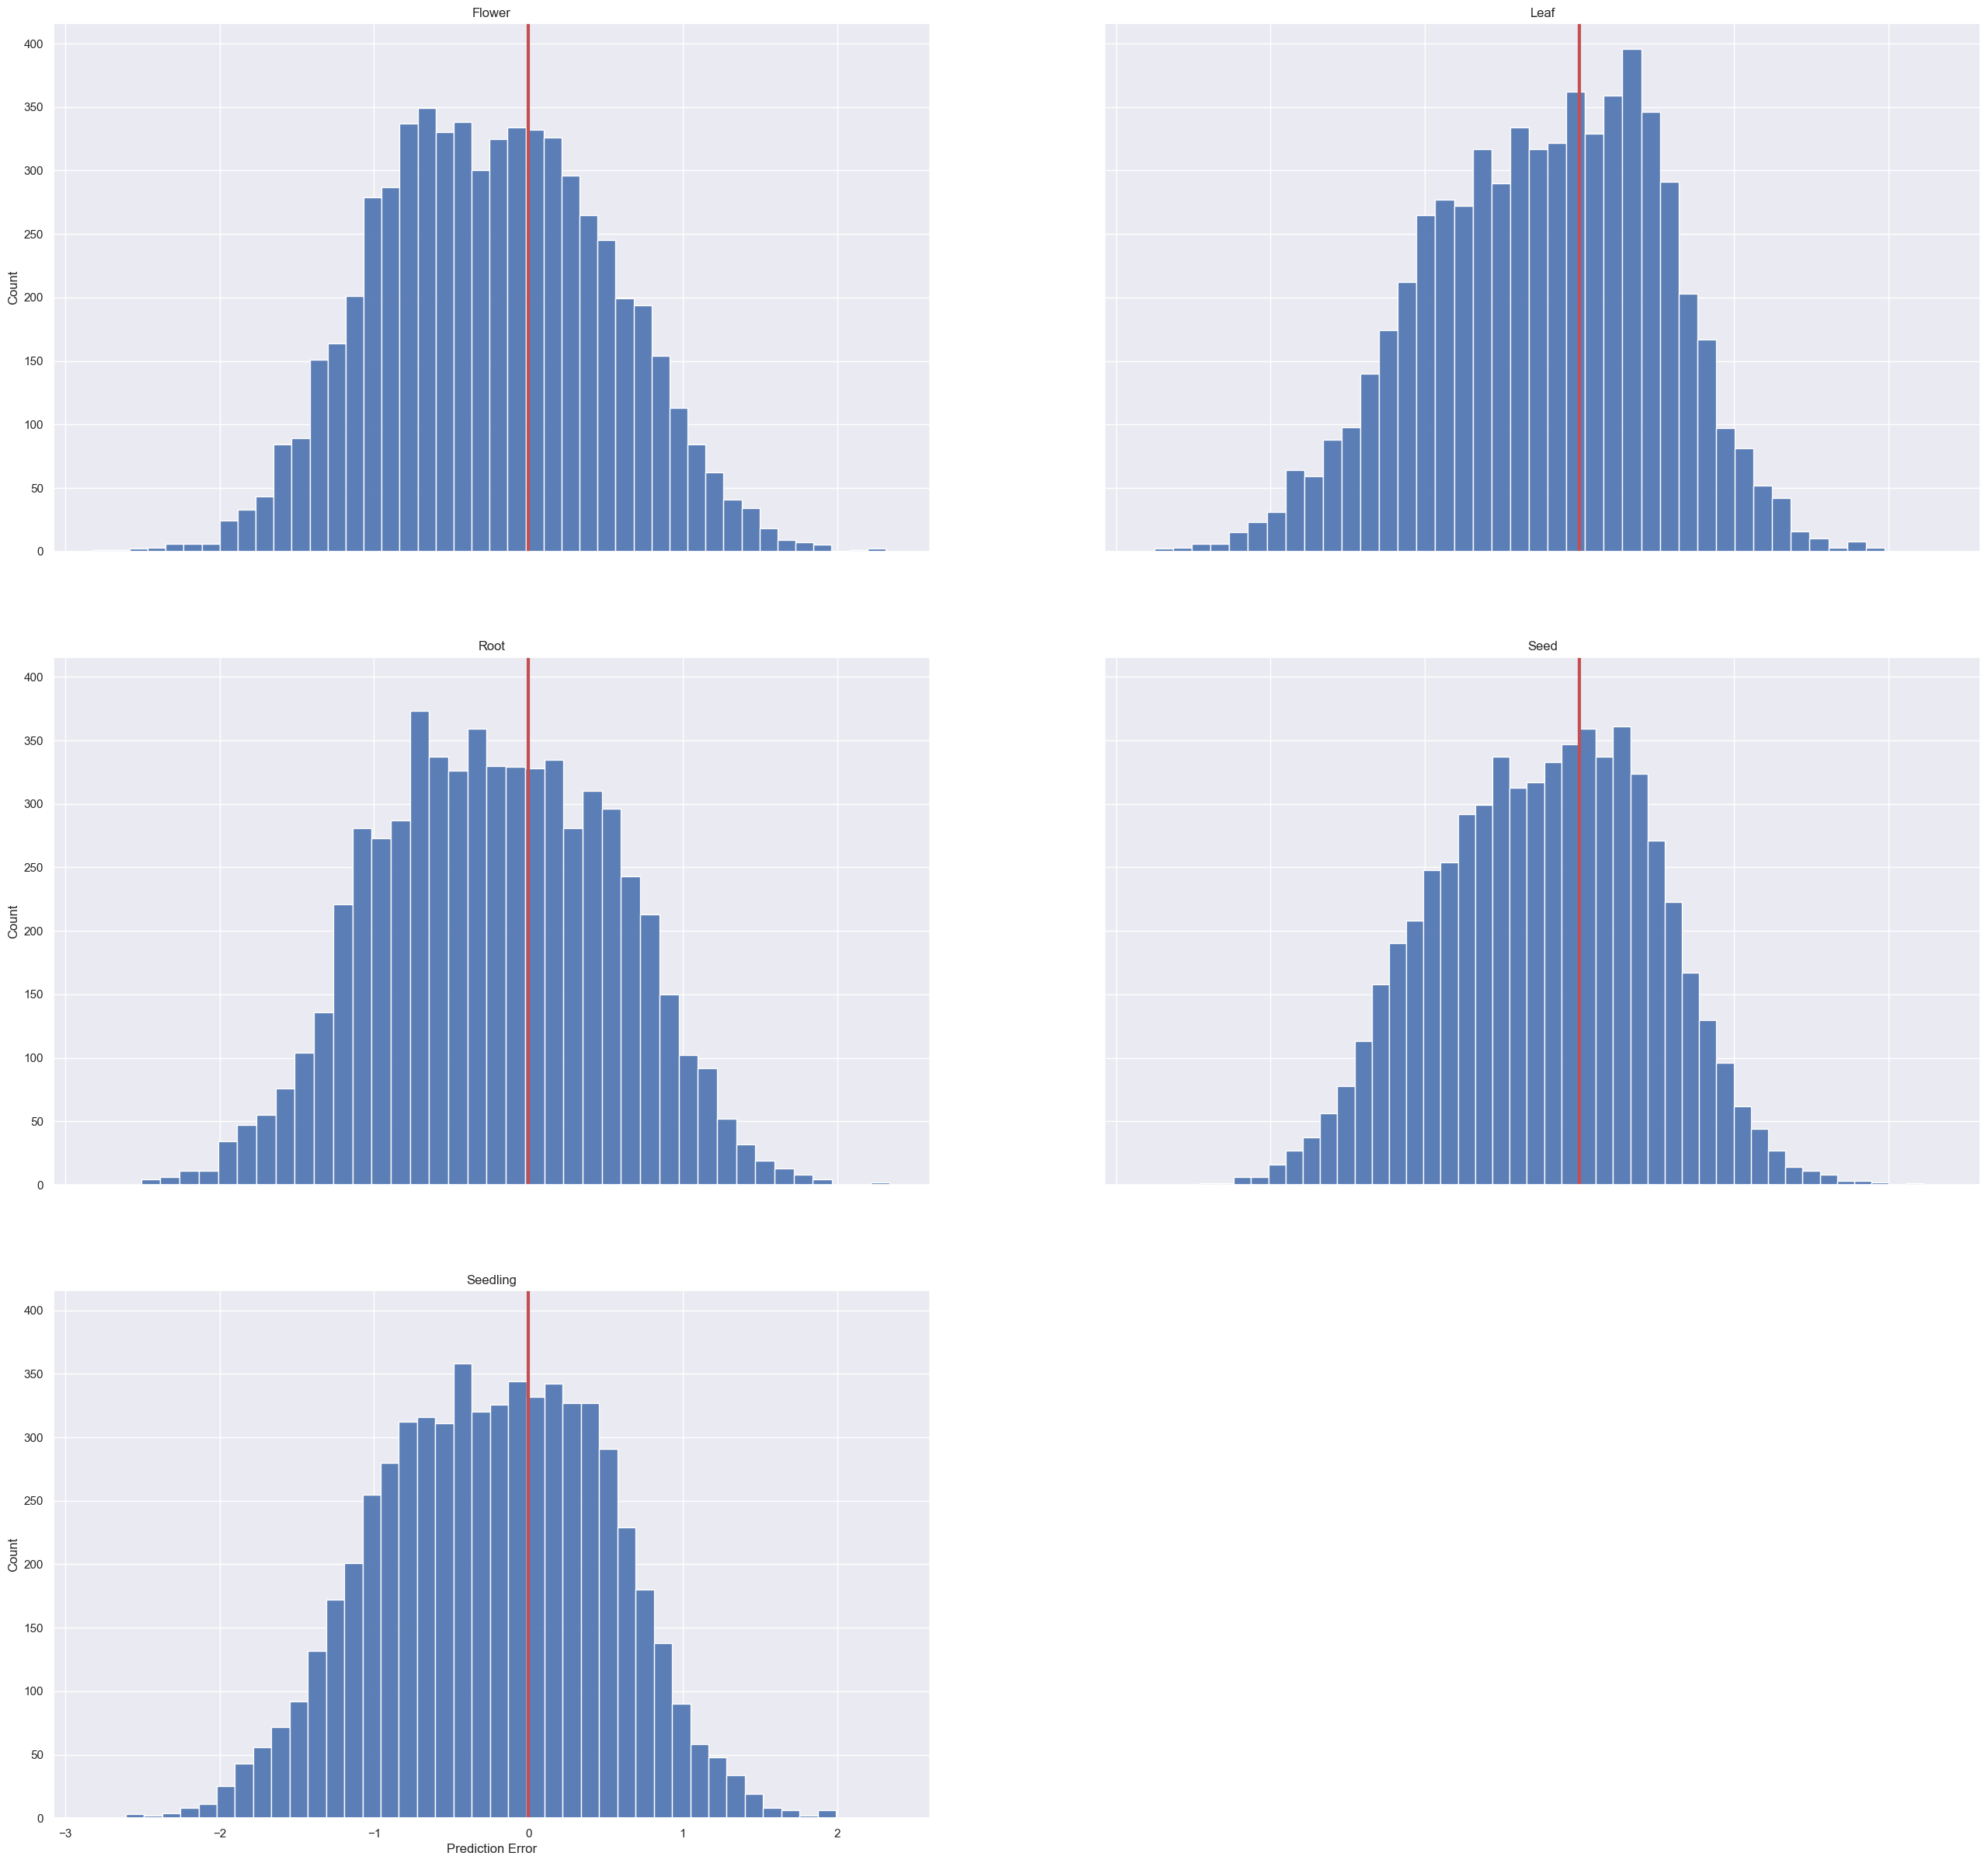

In [30]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

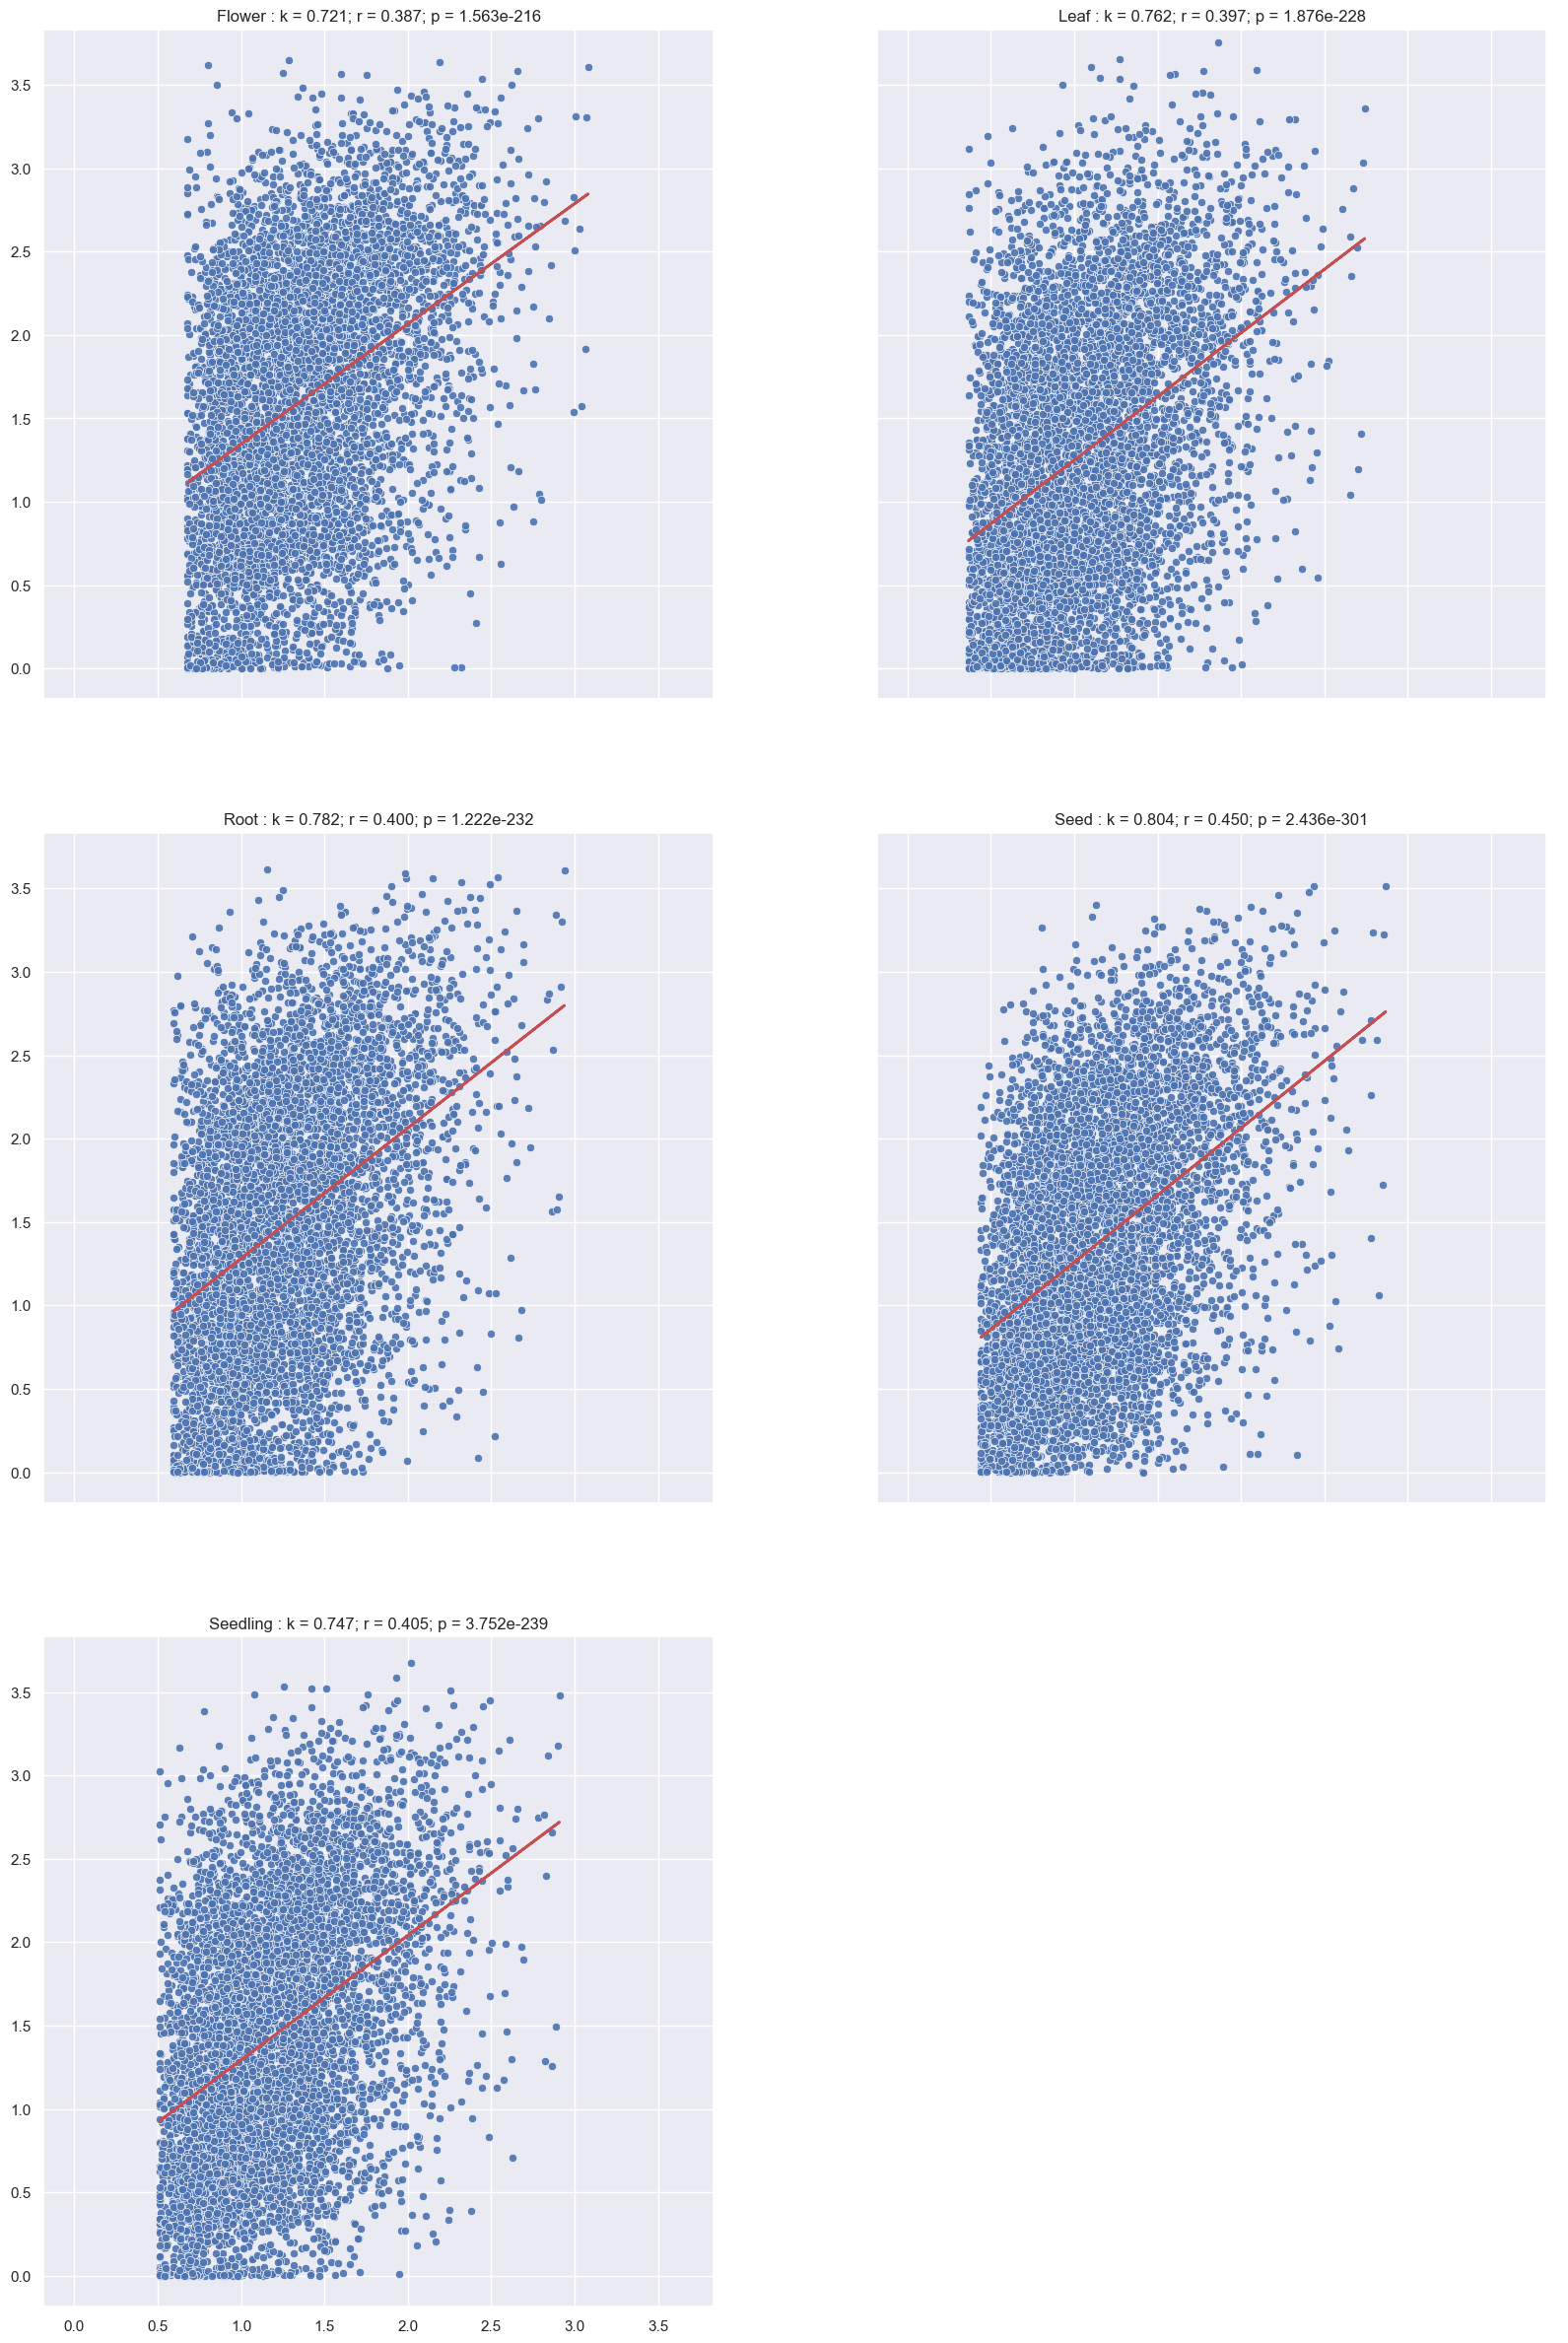

In [31]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-last')
)

### 5.1.4 Mutation

In [32]:
# Evaluate the mutations

report = cnn_model.eval_regressor(
	model  = model,
	params = params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
			'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		}
	}
)

print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

MAE Loss :  0.54949
MSE Loss :  0.46257


In [33]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [34]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT4G08850.1 AT5G25160.1 AT1G72240.1 AT1G04360.1 AT1G78160.2 AT1G10030.1 AT1G07900.1 AT1G29290.1 AT4G18040.1 AT5G19510.1
 AT3G48040.1 AT5G56490.1 AT5G26980.2 AT3G29020.2 AT1G09060.1 AT3G49900.2 AT4G19610.1 AT5G25800.2 AT3G24630.1 AT2G31320.1
 AT3G56230.1 AT2G18780.1 AT4G36870.2 AT2G01590.2 AT5G22780.1


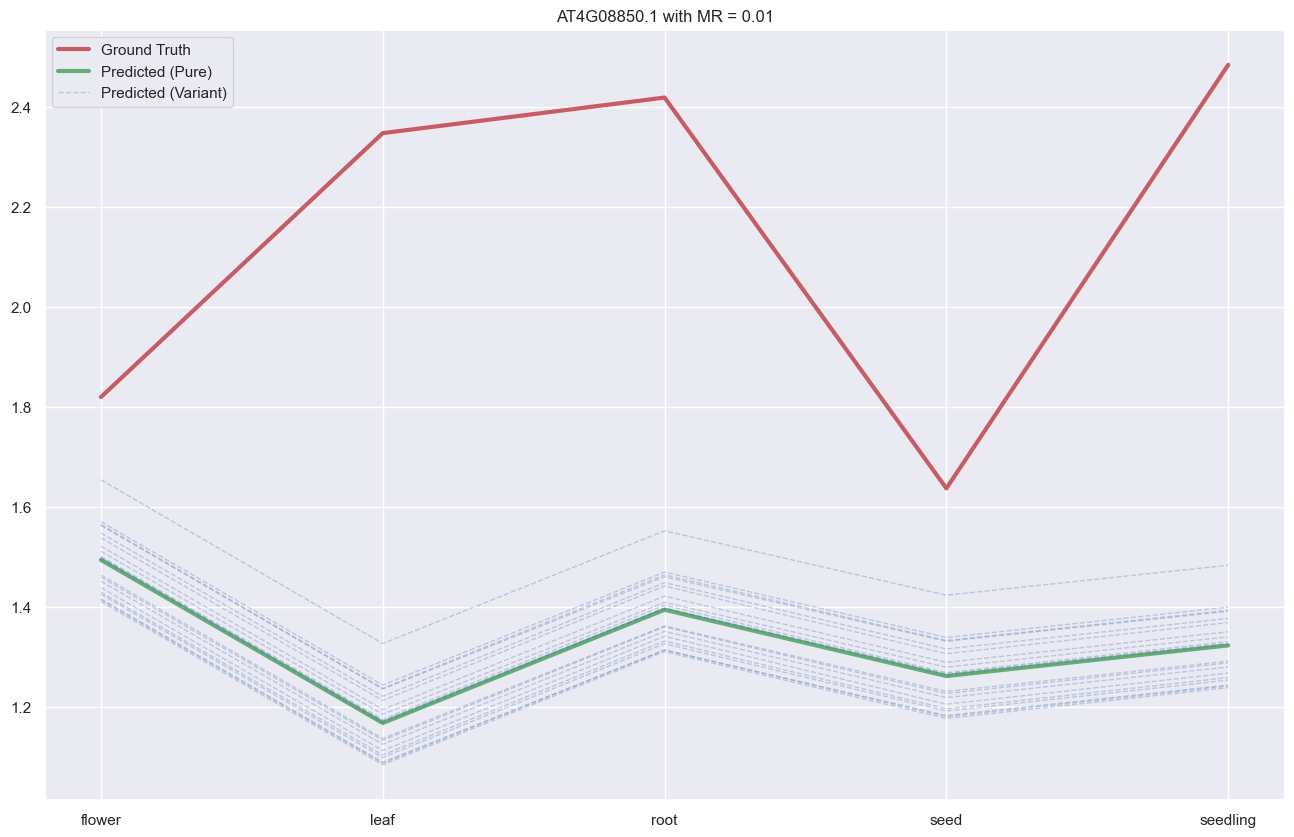

In [35]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = tpm_order
)

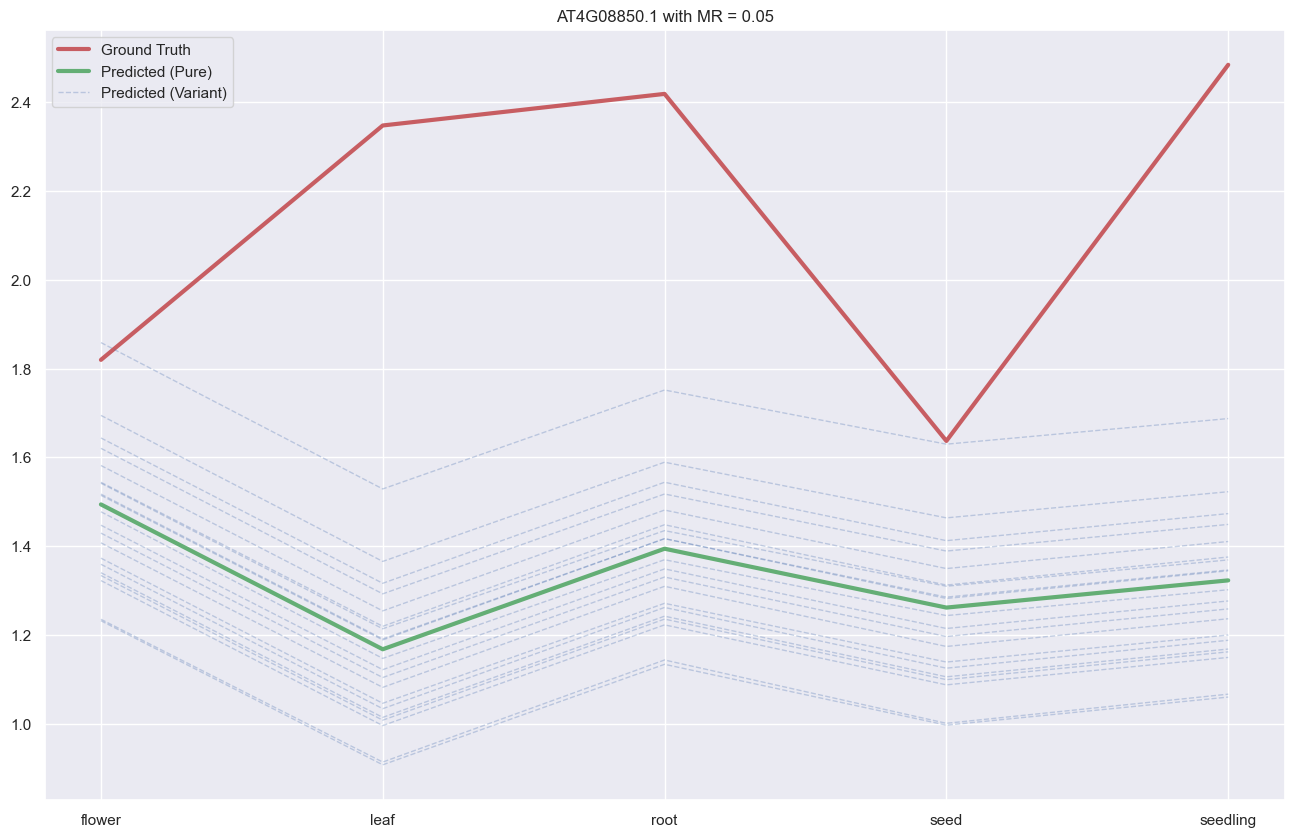

In [36]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = tpm_order
)

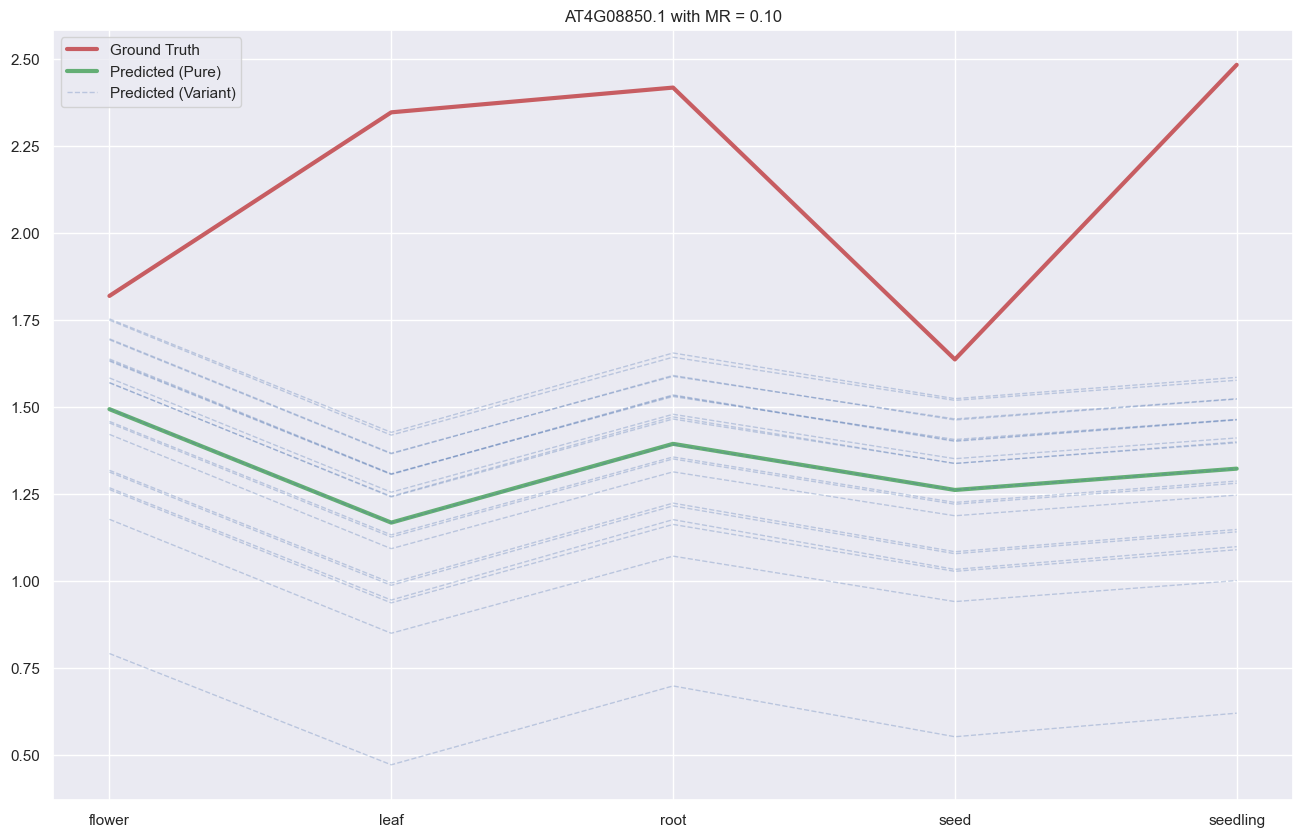

In [37]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = tpm_order
)

## 5.2 Best Model

### 5.2.1 Evaluation

In [38]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print(' Loss : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 18
 Loss : 0.51888


<All keys matched successfully>

In [39]:
# Evaluate the full model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score :  0.16452
MAE Loss :  0.59529
MSE Loss :  0.52129


### 5.2.2 Custom

In [40]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT5G46190.2
True : [ 1.53642    1.17302    1.36030    1.47633    1.30361]
Pred : [ 1.50377    1.19451    1.43896    1.28166    1.35094]
 MAE : [ 0.03265    0.02149    0.07866    0.19467    0.04733]
 MSE : [ 0.00107    0.00046    0.00619    0.03790    0.00224]
 R2  : [ 0.20900    0.20480    0.15156    0.20139    0.20236]

Gene : AT1G20990.1
True : [ 0.69447    0.19487    0.55025    0.27255    0.43521]
Pred : [ 1.05940    0.75741    0.96389    0.82936    0.90212]
 MAE : [ 0.36493    0.56254    0.41363    0.55681    0.46690]
 MSE : [ 0.13317    0.31645    0.17109    0.31004    0.21800]
 R2  : [ 0.14831    0.18378    0.14017    0.27172    0.20871]



In [41]:
# Display the evaluation accuracy, as well as the amount of over and under predictions

dataframe = cnn_util.display_regression_accuracy(
	report    = report,
	order     = tpm_order,
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:6.2f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy :  40.28 %



Group  Total  Count  Accuracy  Avg MAE  Std MAE
3      seed   6080   2919    48.010    0.563    0.380
1      leaf   6080   2530    41.612    0.613    0.417
4  seedling   6080   2496    41.053    0.589    0.405
2      root   6080   2400    39.474    0.613    0.422
0    flower   6080   1899    31.234    0.599    0.415

### 5.2.3 Visualization

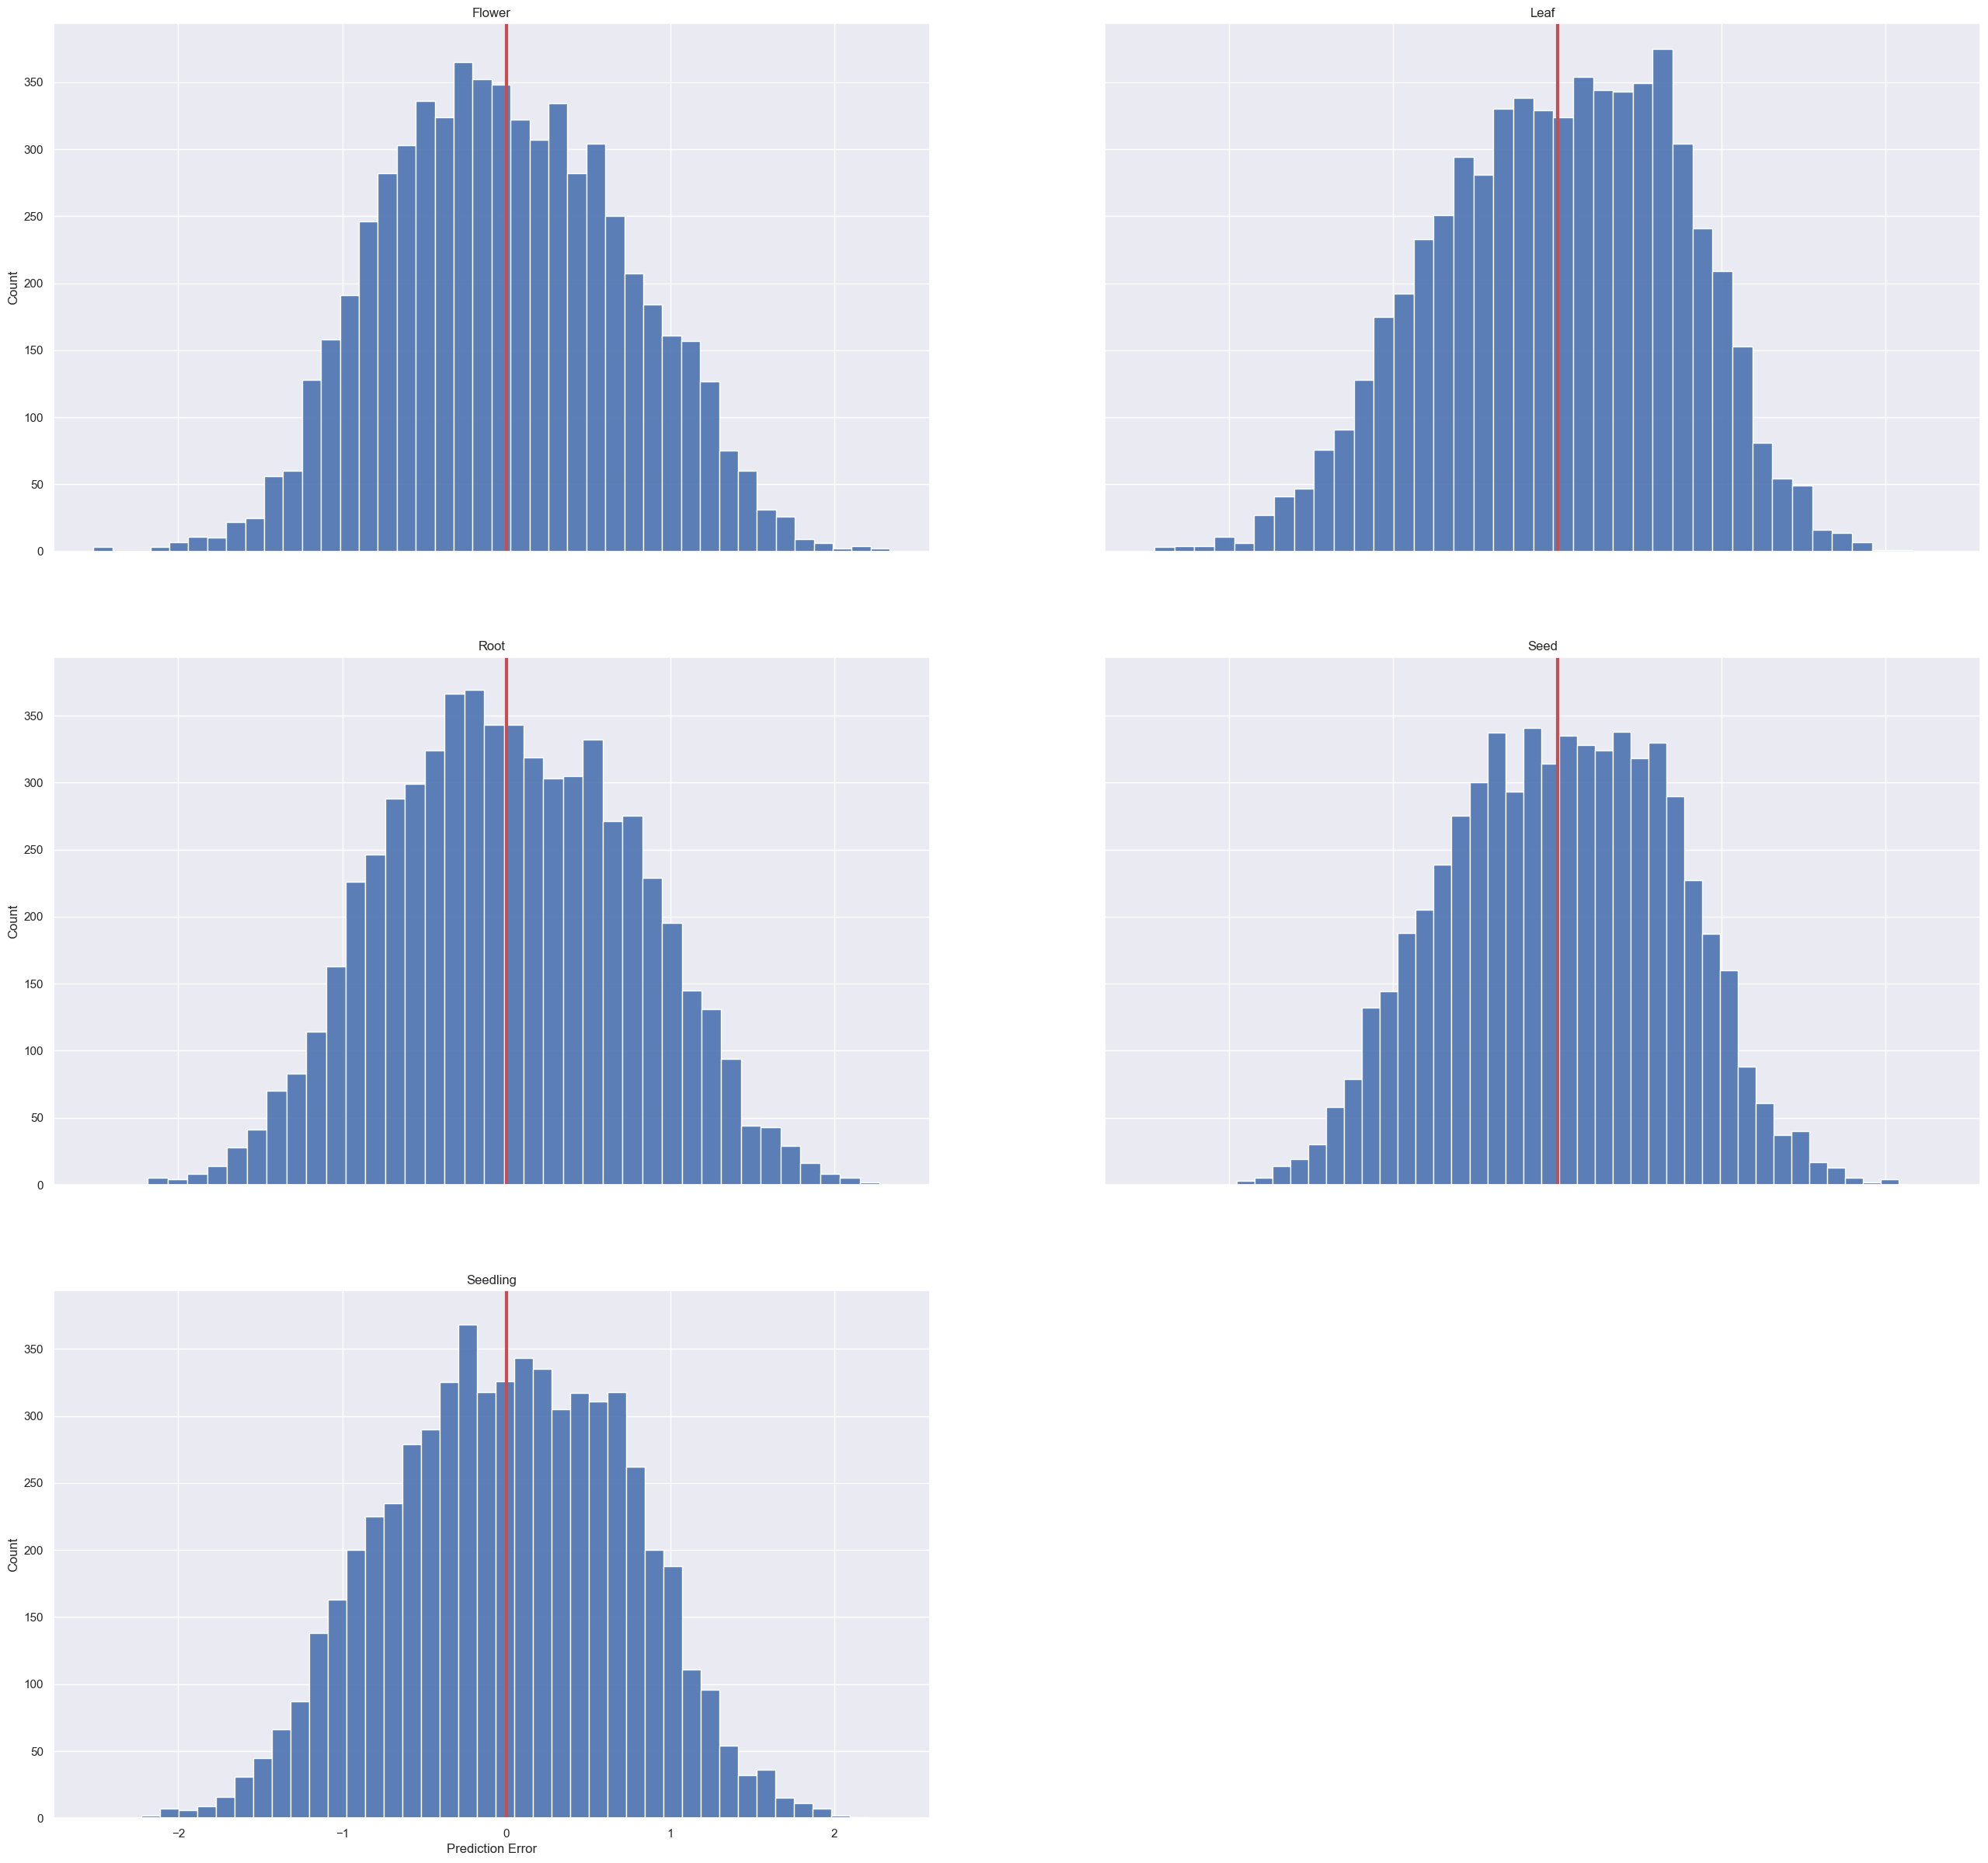

In [42]:
# Display prediction error per group

cnn_plot.show_prediction_error_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

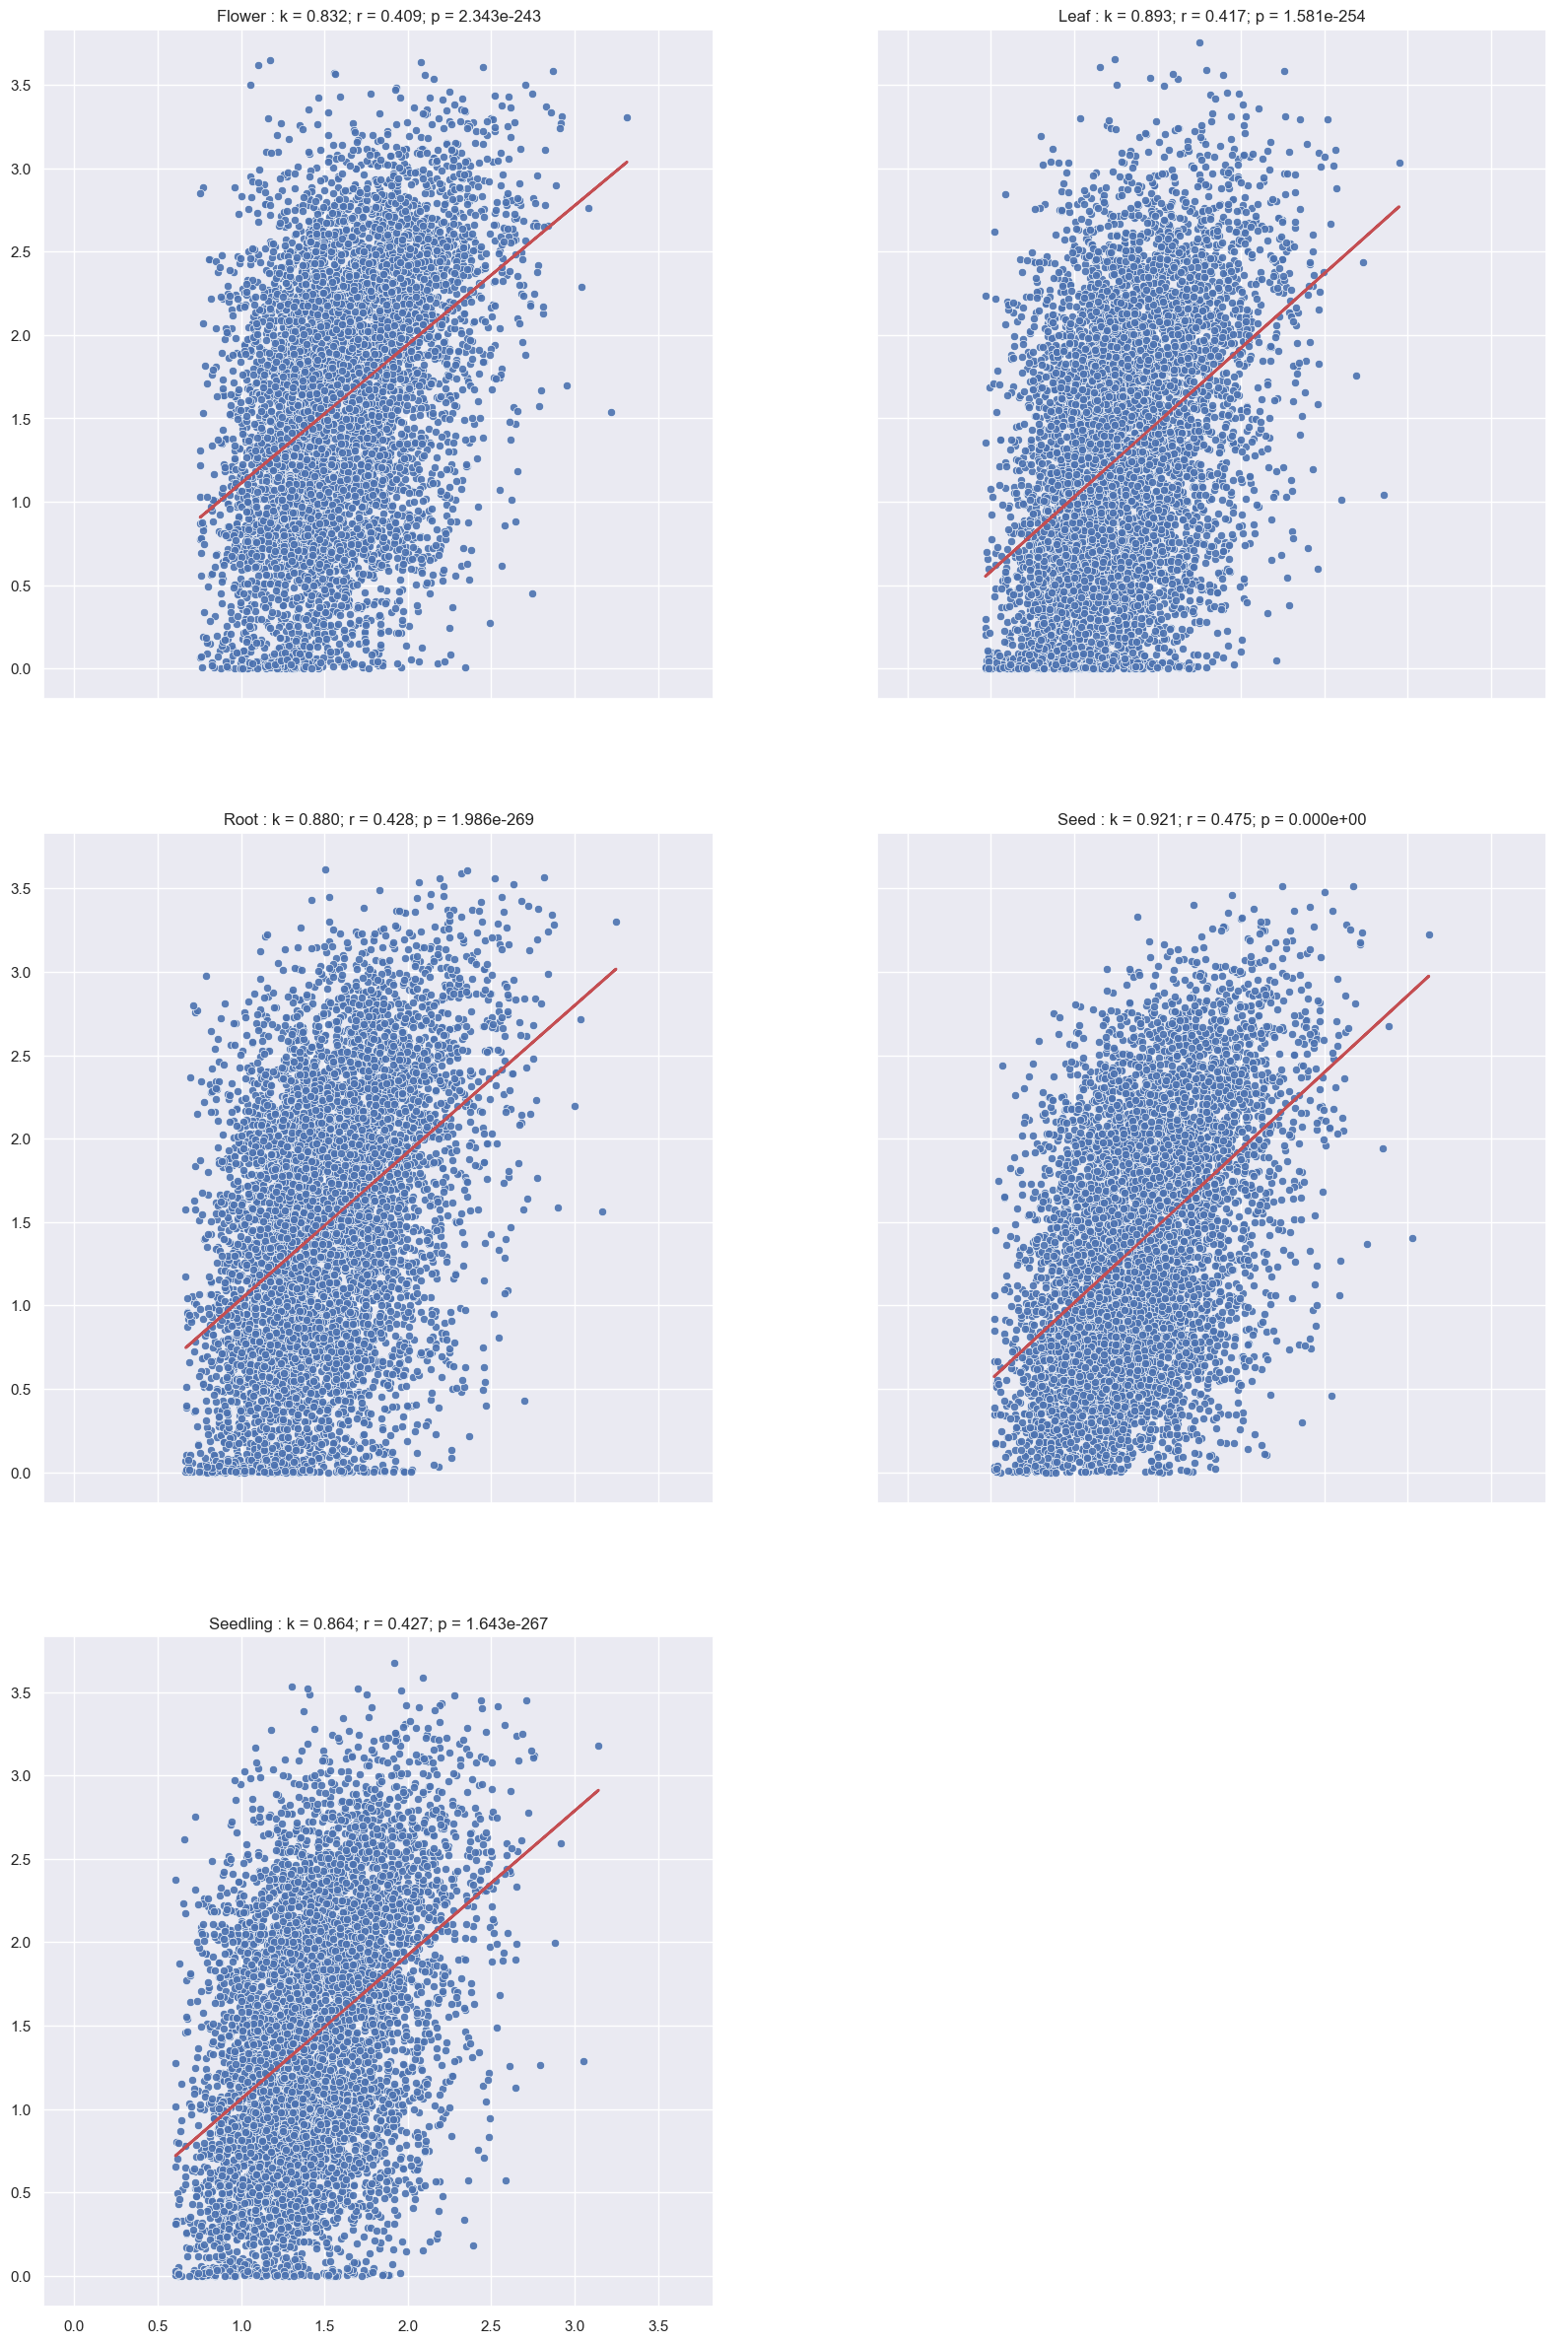

In [43]:
# Display prediction linear regression per group

cnn_plot.show_linear_regression_grid(
	report   = report,
	order    = tpm_order,
	filename = os.path.join(OUT_PLOT, model.__name__ + '-best')
)

### 5.2.4 Mutation

In [44]:
# Evaluate the mutations

report = cnn_model.eval_regressor(
	model  = model,
	params = params | {
		'test_dataloader' : mutation_dataloader,
		'metrics' : {
			'mse'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mse'),
			'mae'   : cnn_model.get_criterion(reduction = 'none', weights = None, query = 'mae'),
		}
	}
)

print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

MAE Loss :  0.54822
MSE Loss :  0.45024


In [45]:
# Transform model report to mutation report

mutation_report = cnn_mutation.get_mutation_report(report = report)

transcript = list(mutation_report.keys())[0]
mutation   = list(mutation_report[transcript].keys())[0]

print('Transcripts : {}'.format(len(mutation_report)))
print('Mutations   : {}'.format(len(mutation_report[transcript])))
print('Variants    : {}'.format(len(mutation_report[transcript][mutation]['label'])))

Transcripts : 25
Mutations   : 6
Variants    : 20


In [46]:
# Print mutations

print(' ' + ' '.join(x if i % 10 != 0 else x + '\n' for i, x in enumerate(mutation_report.keys(), start = 1)))

 AT1G04360.1 AT5G22780.1 AT3G49900.2 AT3G29020.2 AT2G01590.2 AT2G31320.1 AT1G72240.1 AT1G29290.1 AT1G10030.1 AT1G07900.1
 AT1G78160.2 AT4G19610.1 AT4G08850.1 AT3G48040.1 AT1G09060.1 AT5G25800.2 AT5G26980.2 AT5G25160.1 AT5G56490.1 AT5G19510.1
 AT4G18040.1 AT3G56230.1 AT2G18780.1 AT4G36870.2 AT3G24630.1


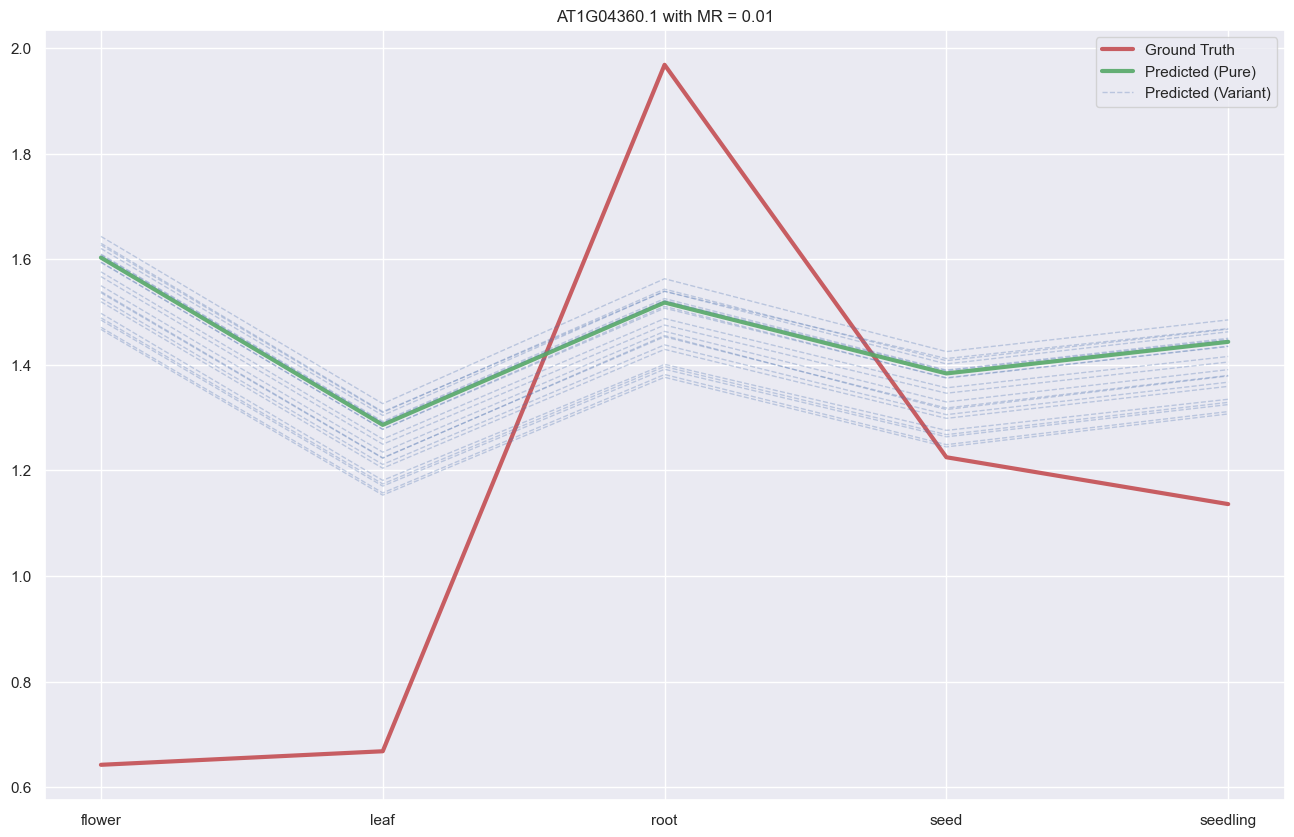

In [47]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M01',
	order      = tpm_order
)

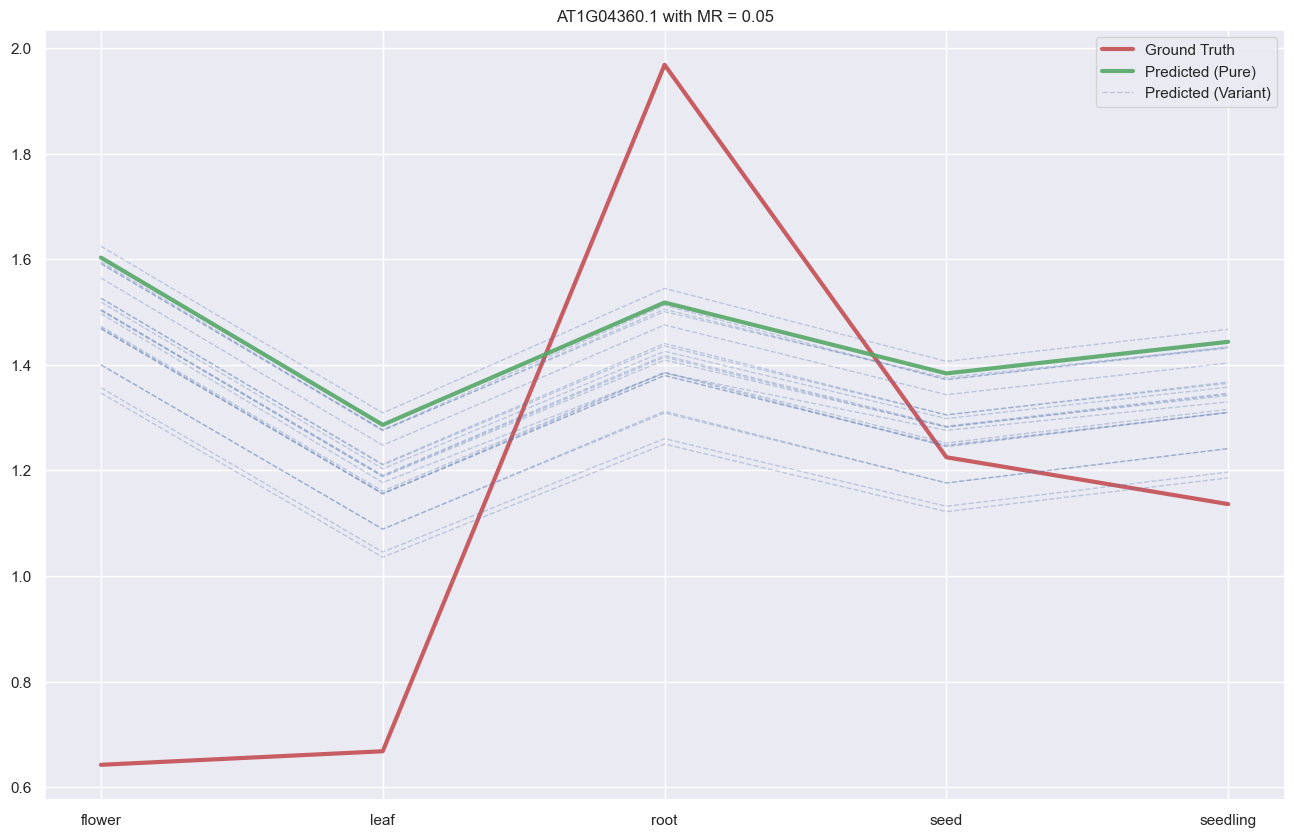

In [48]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M05',
	order      = tpm_order
)

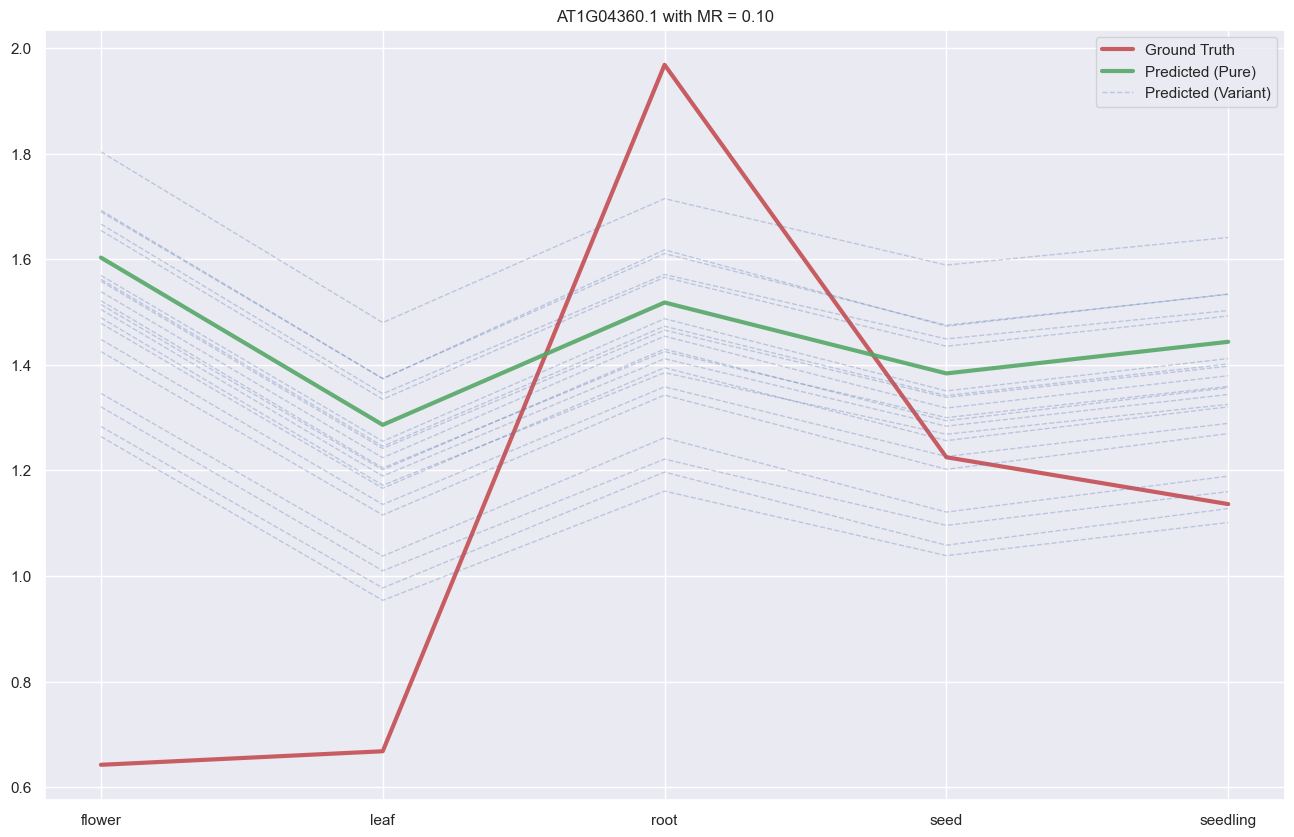

In [49]:
# Plot single transcript mutation variant predictions

cnn_mutation.plot_mutation_regression(
	report     = mutation_report,
	transcript = None,
	mutation   = 'M10',
	order      = tpm_order
)